# Data Processing & Feature Engineering


---


1.   Load json type training/testing data into dataframe
2.   Basic data processing, including timeseries transformation and analysis 
3.   Extract different features from the data for different sequential models, mainly BERT NLP model and SGT model
4.   Different feature datas are generated seperately according to the needs of the model, but we aggregate all lines of codes used here. Please comment out unnecessary codes by yourselves when running the codes


## Data Loading

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Genarate Options

In [ ]:
if_use_test_data = False
if_without_NAs = False
if_all_NAs = False
agree_with_2019 = False

# ## test without NAs
# if_use_test_data = True
# if_without_NAs = True
# if_all_NAs = False

# ## test all NAs
# if_use_test_data = True
# if_without_NAs = False
# if_all_NAs = True

# ## train without NAs
# if_use_test_data = False
# if_without_NAs = True
# if_all_NAs = False

# ## train all NAs
# if_use_test_data = False
# if_without_NAs = False
# if_all_NAs = True

if if_use_test_data:
  dataset = 'testing '
else:
  dataset = 'training '

name = ''
if if_without_NAs:
  name = ' without NAs'
if if_all_NAs:
  name = ' all NAs'

save_file_path = '/content/drive/MyDrive/Spring 2021/Processed Data/'+ dataset+ 'March 21'+ name +'.csv'

if_want_dictionary = False

In [ ]:
%%time
sequential_data = []

if if_use_test_data:
  with open(r'/content/drive/My Drive/data_test.json', 'r') as f:
      for line in f:
          sequential_data.append(json.loads(line))
else:
  with open(r'/content/drive/My Drive/data_train.json', 'r') as f:
    for line in f:
        sequential_data.append(json.loads(line))

CPU times: user 7.71 s, sys: 325 ms, total: 8.04 s
Wall time: 8.26 s


In [ ]:
#By reading the README file for the data provided, knowing that data for each application is divided into two parts。
#The first part (driver) includes all the basic information of an individual application, e.g. new user or not, time of application, overdue, etc.
#The second part (behavior) includes the sequential information of the application. Refer to the README file for more information.
#We use two dictionaries to load two parts of data seperately to prepare for transforming into dataframe.
%%time
sequential_driver = {} 

sequential_behavior = {}

for item in sequential_data:   
    user_id = item[0]
    application_time = int(item[1]['order_info']['order_time'])
    sequential_driver.update({f"{user_id}|{application_time}" : item[1]['order_info']})
    sub_data = [x for x in item[1]['data']]
    sequential_behavior.update({f"{user_id}|{application_time}":sub_data})

CPU times: user 1.64 s, sys: 4.8 ms, total: 1.64 s
Wall time: 1.65 s


In [ ]:
#Load driver into dataframe, seperate user_id and application_time
%%time
driver = pd.DataFrame(sequential_driver).T.reset_index()
driver['user_id'] = driver['index'].apply(lambda x : x.split('|')[0])
driver['application_time'] = driver['index'].apply(lambda x : x.split('|')[1])

CPU times: user 6.54 s, sys: 25.3 ms, total: 6.57 s
Wall time: 6.59 s


In [ ]:
#timeseries transformation
driver['application_date'] = pd.to_datetime(driver['order_time'],unit='ms')
driver["day_of_week"]=(driver["application_date"].dt.dayofweek+1).astype(str) 
driver["hour_of_day"]=(driver["application_date"].dt.hour//4+1).astype(str) 

In [ ]:
#load behavior into dataframe
%%time
behavior = []
for user_keys in sequential_behavior:    
    user_id, application_time = user_keys.split("|")
    index=user_keys
    for item in sequential_behavior[user_keys]:    
        subitem = item.copy()
        subitem.update({"user_id":user_id, "application_time":application_time,"index":index})
        behavior.append(subitem)
behavior = pd.DataFrame(behavior)

CPU times: user 13.1 s, sys: 95.6 ms, total: 13.2 s
Wall time: 13.3 s


In [ ]:
driver['index'].nunique()

80000

In [ ]:
driver

,index,overdue,new_client,order_time,user_id,application_time,application_date,day_of_week,hour_of_day
0,cd7dbe38d33f4bd0bf259a7bc6629edc|1508878740000,0.0,0.0,1.508879e+12,cd7dbe38d33f4bd0bf259a7bc6629edc,1508878740000,2017-10-24 20:59:00,2,6
1,b88e4b3069d14ee59c7abd9ba1fb1238|1509065340000,0.0,1.0,1.509065e+12,b88e4b3069d14ee59c7abd9ba1fb1238,1509065340000,2017-10-27 00:49:00,5,1
2,a171878cfd444b5e94f4495ba6bf458b|1509305940000,0.0,0.0,1.509306e+12,a171878cfd444b5e94f4495ba6bf458b,1509305940000,2017-10-29 19:39:00,7,5
3,8f302e4e1ac64a32955fd8b6d3a24ae5|1507658880000,0.0,0.0,1.507659e+12,8f302e4e1ac64a32955fd8b6d3a24ae5,1507658880000,2017-10-10 18:08:00,2,5
4,707fc058427c436eb6d7704e1f650b8a|1507748400000,0.0,1.0,1.507748e+12,707fc058427c436eb6d7704e1f650b8a,1507748400000,2017-10-11 19:00:00,3,5
...,...,...,...,...,...,...,...,...,...
79995,7b7fc642b7ab42ffb01ea46297f675ec|1508861880000,0.0,0.0,1.508862e+12,7b7fc642b7ab42ffb01ea46297f675ec,1508861880000,2017-10-24 16:18:00,2,5
79996,5eb16ed01ebc400b94e9d828ecf73412|1509157320000,0.0,0.0,1.509157e+12,5eb16ed01ebc400b94e9d828ecf73412,1509157320000,2017-10-28 02:22:00,6,1
79997,8aa50e1fe87d434a8dd8d8d29628e582|1507020960000,0.0,1.0,1.507021e+12,8aa50e1fe87d434a8dd8d8d29628e582,1507020960000,2017-10-03 08:56:00,2,3
79998,8873f96ca1524e999720842794d090f1|1508036220000,0.0,0.0,1.508036e+12,8873f96ca1524e999720842794d090f1,1508036220000,2017-10-15 02:57:00,7,1


In [ ]:
behavior['index'].nunique()

79984

In [ ]:
behavior

,pname,pstime,petime,pid,sid,user_id,application_time,index
0,loan_index,1508187674573,1508187679406,1508187673863X12898,1508187673836,cd7dbe38d33f4bd0bf259a7bc6629edc,1508878740000,cd7dbe38d33f4bd0bf259a7bc6629edc|1508878740000
1,login,1508905680008,1508905689123,1508905673364X10645,1508905673195,cd7dbe38d33f4bd0bf259a7bc6629edc,1508878740000,cd7dbe38d33f4bd0bf259a7bc6629edc|1508878740000
2,loan_index,1508905689145,1508905697280,1508905673364X10645,1508905673195,cd7dbe38d33f4bd0bf259a7bc6629edc,1508878740000,cd7dbe38d33f4bd0bf259a7bc6629edc|1508878740000
3,loan_index,1508906568305,1508907061062,1508905868806X10655,1508907057937-481306,cd7dbe38d33f4bd0bf259a7bc6629edc,1508878740000,cd7dbe38d33f4bd0bf259a7bc6629edc|1508878740000
4,operator,1508907061067,1508907089489,1508905868806X10655,1508907075420-3057,cd7dbe38d33f4bd0bf259a7bc6629edc,1508878740000,cd7dbe38d33f4bd0bf259a7bc6629edc|1508878740000
...,...,...,...,...,...,...,...,...
3413012,bind_debit_card,1507372989006,1507373001507,1507372982795X12730,1507372983423,b50e1a4b9d52483fba70e76c06300cfe,1507344240000,b50e1a4b9d52483fba70e76c06300cfe|1507344240000
3413013,bind_debit_card,1507373014556,1507373015154,1507372982795X12730,1507372983423,b50e1a4b9d52483fba70e76c06300cfe,1507344240000,b50e1a4b9d52483fba70e76c06300cfe|1507344240000
3413014,loan_index,1507373078908,1507373084541,1507372982795X12730,1507372983423,b50e1a4b9d52483fba70e76c06300cfe,1507344240000,b50e1a4b9d52483fba70e76c06300cfe|1507344240000
3413015,loan_submission,1507373084670,1507373091101,1507372982795X12730,1507372983423,b50e1a4b9d52483fba70e76c06300cfe,1507344240000,b50e1a4b9d52483fba70e76c06300cfe|1507344240000


In [ ]:
behavior[behavior['index']=='61ae03c17b4d4d189e4611cc0fcc912b|1507379100000']

,pname,pstime,petime,pid,sid,user_id,application_time,index


Free up memory spaces by deleting data that has already been processed into dataframe

In [ ]:
del sequential_driver

In [ ]:
del sequential_behavior

In [ ]:
del sequential_data

Making sure that behavior data (sequential data of each application) are in order of time. This is important because the sequence is an important feature here in our models.

In [ ]:
behavior = behavior.sort_values(['user_id', 'application_time', 'pstime'])

## Split NAs for pid and sid

In [ ]:
if if_without_NAs:
  behavior = behavior[~behavior['pid'].isnull()] # without NAs
if if_all_NAs:
  behavior = behavior[behavior['pid'].isnull()] # with all NAs
behavior.head()

,pname,pstime,petime,pid,sid,user_id,application_time,index
1845536,login,1506775233432,1506775246507,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000
1845537,loan_index,1506775246833,1506775251978,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000
1845538,loan_submission,1506775252184,1506775260156,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000
1845539,loan_submission,1506775330139,1506775342777,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000
1845540,loan_index,1506775342940,1506775353732,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000


## More timeseries transformation and analysis

### Transformation and analysis of page stay time (time spent staying on a same page during an applicatoin)

In [ ]:
behavior["stay_time"]=(behavior["petime"]-behavior["pstime"])/1000               #change unit from ms to s

In [ ]:
behavior=behavior[(behavior["stay_time"]>0) & (behavior['stay_time']<=88)] 

In [ ]:
#drop all the data where stay_time<0 or stay_time>=88 where 99th quantile is 88 (too long). This step is necessary to eliminate extreme outliers and stablize the performance of our model
if not agree_with_2019:
  behavior=behavior[(behavior["stay_time"]>0) & (behavior['stay_time']<=88)]       

In [ ]:
behavior['stay_time']

1845536    13.075
1845537     5.145
1845538     7.972
1845539    12.638
1845540    10.792
            ...  
1077092     5.597
1077093    14.135
1077050     5.507
1077051    12.423
1077052    13.381
Name: stay_time, Length: 3375484, dtype: float64

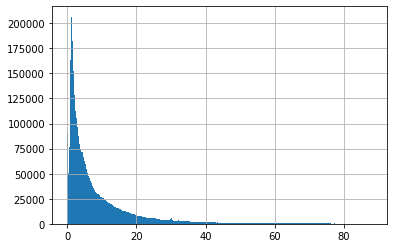

In [ ]:
behavior['stay_time'].hist(bins=300)

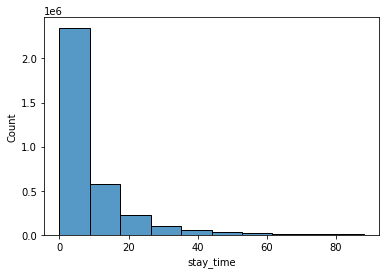

In [ ]:
# sns.histplot(behavior.stay_time)
sns.histplot(behavior['stay_time'],bins=10)

we can see that the stay_time is approximately exponentially distributed. However, we are not utilizing the distribution of stay_time in out model. Instead, we are just cutting them into 10 equally distributed bins by percentile of number of observations, and map each bin to an alphabet 'A','B', ..., 'J'

In [ ]:
percentile=np.arange(0,1,0.2)

In [ ]:
percentile=percentile+0.2

In [ ]:
percentile

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [ ]:
stay_time_cutoff=behavior.stay_time.quantile(percentile).values

In [ ]:
stay_time_map={(value,stay_time_cutoff[key+1]):str(key+2) for key,value in enumerate(stay_time_cutoff) if key<4}

In [ ]:
if if_use_test_data:
  stay_time_map[(0,1.611)]='1'
else:
  stay_time_map[(0,1.6109999999999998)]='1'
alphabet=['2','3','4','5']
for key,alpha in zip(stay_time_map.keys(),alphabet):
  stay_time_map[key]=alpha
stay_time_map


{(0, 1.611): '1',
 (1.611, 3.189): '2',
 (3.189, 6.201): '3',
 (6.201, 13.181): '4',
 (13.181, 88.0): '5'}

In [ ]:
#function that map stay_time and lag_time to respective labels
def mapping(time,maps):
    for key in maps.keys():
        if key[0]<=time<=key[1]:
            return maps[key]

In [ ]:
#map stay_time to their respective alphabetical labels
behavior['stay_time_label']=behavior.stay_time.apply(lambda x:mapping(x,maps=stay_time_map))   

### Transformation and analysis of page lag time (time difference between finishing the last page and starting the next page during an application)

In [ ]:
#transform ms to s at the same time, and if this is the first page, assign lag_time of 0
behavior=behavior.assign(lagg=lambda x:np.where(x.user_id.shift(1)==x.user_id,(x.pstime-x.petime.shift(1))/1000,0))    

In [ ]:
#drop where lag_time>99ths quantile value and lag_time<0
if not agree_with_2019:
  behavior=behavior[(behavior.lagg<=behavior.lagg.quantile(0.99)) & (behavior.lagg>=0)]         

Similar to actions taken above, we cut lag_time into 10 bins with equal number of observations. Each bin contains 10% of the total number of observations, and map each bin to an alphabet. 
We can safely ignore the fact that we are using the same alphabets as above, because this is taken into consideration during feature engineering and model selection. 

In [ ]:
lagg_cutoff=behavior.lagg.quantile(percentile).values

In [ ]:
lagg_map={(value,lagg_cutoff[key+1]):str(key+2) for key,value in enumerate(lagg_cutoff) if key<4}
if if_use_test_data:
  lagg_map[(0,0.196)]='1'
else:
  lagg_map[(0,0.2)]='1'
for key,alpha in zip(lagg_map.keys(),alphabet):
  lagg_map[key]=alpha

In [ ]:
lagg_map

{(0, 0.196): '1',
 (0.196, 2.216): '2',
 (2.216, 7.259): '3',
 (7.259, 36.907): '4',
 (36.907, 1062476.859): '5'}

In [ ]:
behavior['lagg_label']=behavior.lagg.apply(lambda x:mapping(x,maps=lagg_map))             #generate label for lagg

Do note that we have changed the labels (alphabets) used throughout the project to fit the needs of different models. In the BERT model, we may have used different models. However, it has no impact on the performance of the model and can safely be used on BERT model as well.

In [ ]:
behavior.drop(columns=['pstime','petime'],inplace=True)    #drop columns pstime and petime as they are no longer needed, freeing up memory space

### Generate labels for pid and sid. 
Specific information of pid and sid, please refer to README file that comes with the data.

In [ ]:
behavior=behavior.assign(pid_label=lambda x:np.where(x.user_id.shift(1)==x.user_id,x.pid.ne(x.pid.shift(1)).astype(int),2))

In [ ]:
behavior=behavior.assign(sid_label=lambda x:np.where(x.user_id.shift(1)==x.user_id,x.sid.ne(x.sid.shift(1)).astype(int),2))

In [ ]:
map2={0:'A',1:'B',2:'C'}

In [ ]:
def mapping2(x,map=map2):
  return map[x]


In [ ]:
behavior.pid_label=behavior.pid_label.apply(lambda x:mapping2(x))

In [ ]:
behavior.sid_label=behavior.sid_label.apply(lambda x:mapping2(x))

In [ ]:
behavior.head() #[['pid','sid','pid_label','sid_label']]

,pname,pid,sid,user_id,application_time,index,stay_time,stay_time_label,lagg,lagg_label,pid_label,sid_label
1845536,login,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000,13.075,4,0.000,1,C,C
1845537,loan_index,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000,5.145,3,0.326,2,A,A
1845538,loan_submission,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000,7.972,4,0.206,2,A,A
1845539,loan_submission,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000,12.638,4,69.983,5,A,A
1845540,loan_index,1506775226199X22539,1506775228698,000128c6454e490597285d39af1dcac4,1509033300000,000128c6454e490597285d39af1dcac4|1509033300000,10.792,4,0.163,1,A,A


In [ ]:
behavior[['pid','sid','pid_label','sid_label']].head()

,pid,sid,pid_label,sid_label
1845536,1506775226199X22539,1506775228698,C,C
1845537,1506775226199X22539,1506775228698,A,A
1845538,1506775226199X22539,1506775228698,A,A
1845539,1506775226199X22539,1506775228698,A,A
1845540,1506775226199X22539,1506775228698,A,A


In [ ]:
sum(behavior['pid'].isnull())/len(behavior)

0.007797276828637381

## Feature Engineering
This section of codes provides a general guideline to produce feature files required for the two models: SGT model and BERT NLP model.

Do note that we used tested our models with a great variation of input features. But it is unnecessary to list out all the codes for each one of them because they are mostly similar to each other, with little differences in formations. Therefore, we believe it is more than enough for you to reproduce all feature files if you just follow the general guidelines provided below.

### SGT models

In [ ]:
features=['pname','stay_time_label','lagg_label','pid_label','sid_label']

The following is another feature file we did for the SGT model, for a single feature 'page_name'. This is a easier version of the above part.

In [ ]:
# behavior.groupby('index').count()

In [ ]:
new_df=pd.DataFrame(behavior.groupby('index').apply(lambda x:' '.join(x.pname.values)+'')) 

In [ ]:
# new_df.head()

In [ ]:
new_df.rename(columns={0:'sentence'},inplace=True)

In [ ]:
new_df.reset_index()

,index,sentence
0,000128c6454e490597285d39af1dcac4|1509033300000,login loan_index loan_submission loan_submissi...
1,0001f8ff2b7f47f5b626de13d85b827f|1507253100000,register loan_index loan_index id_verify loan_...
2,00025206698e4d68b21fc77867399e83|1508103900000,login loan_index loan_index loan_index loan_in...
3,00025206698e4d68b21fc77867399e83|1509248520000,loan_index loan_index loan_index loan_index lo...
4,0002a7c19ab245bab22c95b15f164f70|1508271180000,login loan_index loan_index login loan_index o...
...,...,...
79944,fffcc62d9b3942dca3cf1e438646ae1f|1508689140000,loan_index loan_index id_verify id_verify id_v...
79945,fffe686cc8ca4da89fd791ea6cafdbcd|1508271840000,login loan_index id_verify id_verify id_verify...
79946,fffe71e9438949f6a8ea6453726e6aca|1508518440000,login loan_index id_verify id_verify id_verify...
79947,fffec6c8c0bd4e0e8293e0bd5d18cecf|1507406160000,register loan_index loan_index loan_index loan...


In [ ]:
new_df=new_df.merge(driver,how='left',on='index')

In [ ]:
new_df['label']=0
new_df.loc[new_df['overdue']>5,'label']=1

In [ ]:
new_df

,index,sentence,overdue,new_client,order_time,user_id,application_time,application_date,day_of_week,hour_of_day,label
0,000128c6454e490597285d39af1dcac4|1509033300000,login loan_index loan_submission loan_submissi...,0.0,0.0,1.509033e+12,000128c6454e490597285d39af1dcac4,1509033300000,2017-10-26 15:55:00,4,4,NaN
1,0001f8ff2b7f47f5b626de13d85b827f|1507253100000,register loan_index loan_index id_verify loan_...,0.0,0.0,1.507253e+12,0001f8ff2b7f47f5b626de13d85b827f,1507253100000,2017-10-06 01:25:00,5,1,NaN
2,00025206698e4d68b21fc77867399e83|1508103900000,login loan_index loan_index loan_index loan_in...,0.0,0.0,1.508104e+12,00025206698e4d68b21fc77867399e83,1508103900000,2017-10-15 21:45:00,7,6,NaN
3,00025206698e4d68b21fc77867399e83|1509248520000,loan_index loan_index loan_index loan_index lo...,0.0,0.0,1.509249e+12,00025206698e4d68b21fc77867399e83,1509248520000,2017-10-29 03:42:00,7,1,NaN
4,0002a7c19ab245bab22c95b15f164f70|1508271180000,login loan_index loan_index login loan_index o...,0.0,0.0,1.508271e+12,0002a7c19ab245bab22c95b15f164f70,1508271180000,2017-10-17 20:13:00,2,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...
79944,fffcc62d9b3942dca3cf1e438646ae1f|1508689140000,loan_index loan_index id_verify id_verify id_v...,0.0,0.0,1.508689e+12,fffcc62d9b3942dca3cf1e438646ae1f,1508689140000,2017-10-22 16:19:00,7,5,NaN
79945,fffe686cc8ca4da89fd791ea6cafdbcd|1508271840000,login loan_index id_verify id_verify id_verify...,0.0,1.0,1.508272e+12,fffe686cc8ca4da89fd791ea6cafdbcd,1508271840000,2017-10-17 20:24:00,2,6,NaN
79946,fffe71e9438949f6a8ea6453726e6aca|1508518440000,login loan_index id_verify id_verify id_verify...,0.0,0.0,1.508518e+12,fffe71e9438949f6a8ea6453726e6aca,1508518440000,2017-10-20 16:54:00,5,5,NaN
79947,fffec6c8c0bd4e0e8293e0bd5d18cecf|1507406160000,register loan_index loan_index loan_index loan...,0.0,1.0,1.507406e+12,fffec6c8c0bd4e0e8293e0bd5d18cecf,1507406160000,2017-10-07 19:56:00,6,5,NaN


In [ ]:
new_df.to_csv('/content/drive/MyDrive/processed_data/SGT/page only '+ dataset +'April 2.csv',index=False)
# new_df = pd.read_csv('page only test Nov 15.csv')

In [ ]:
len(behavior['pid'])

3318851

In [ ]:
sum(behavior['pid'].isnull())

25878

In [ ]:
behavior[behavior['index']=='00008a736dcc4d099436cda07d41bdc4|1507436280000']

,pname,pid,sid,user_id,application_time,index,stay_time,stay_time_label,lagg,lagg_label,pid_label,sid_label


In [ ]:
behavior.groupby('index').count()

,pname,pid,sid,user_id,application_time,stay_time,stay_time_label,lagg,lagg_label,pid_label,sid_label
index,,,,,,,,,,,
000128c6454e490597285d39af1dcac4|1509033300000,46,46,46,46,46,46,46,46,46,46,46
0001f8ff2b7f47f5b626de13d85b827f|1507253100000,75,75,75,75,75,75,75,75,75,75,75
00025206698e4d68b21fc77867399e83|1508103900000,47,47,47,47,47,47,47,47,47,47,47
00025206698e4d68b21fc77867399e83|1509248520000,23,23,23,23,23,23,23,23,23,23,23
0002a7c19ab245bab22c95b15f164f70|1508271180000,236,236,236,236,236,236,236,236,236,236,236
...,...,...,...,...,...,...,...,...,...,...,...
fffcc62d9b3942dca3cf1e438646ae1f|1508689140000,46,46,46,46,46,46,46,46,46,46,46
fffe686cc8ca4da89fd791ea6cafdbcd|1508271840000,29,29,29,29,29,29,29,29,29,29,29
fffe71e9438949f6a8ea6453726e6aca|1508518440000,61,61,61,61,61,61,61,61,61,61,61


In [ ]:
# should be no records
behavior[behavior['stay_time_label'].isnull()]

,pname,pid,sid,user_id,application_time,index,stay_time,stay_time_label,lagg,lagg_label,pid_label,sid_label


In [ ]:
behavior['pid_label'] = behavior['pid_label'].apply(lambda x:str(x))
behavior['sid_label'] = behavior['sid_label'].apply(lambda x:str(x))
for feature in features:
  df=pd.DataFrame(behavior.groupby('index').apply(lambda x:' '.join(x[feature].values)))  #Most important step in feature engineering. For each application, we are combining the information we want into a sequence
  df.rename(columns={0:feature+'_sequence'},inplace=True)
  df.reset_index()
  new_df=new_df.merge(df,on='index',how='left')

In [ ]:
# new_df=new_df.merge(driver,how='left',on='index')

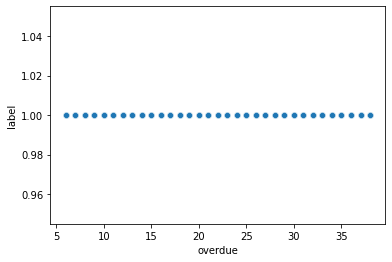

In [ ]:
#for testing data, there is no label given. So we plot out the distribution based on 'label' and 'overdue' in training data
import seaborn as sns
sns.scatterplot(x='overdue',y='label',data=new_df)

In [ ]:
# Based on observation, we know to map label to 1 if overdue>5
new_df['label']=0
new_df.loc[new_df['overdue']>5,'label']=1

In [ ]:
new_df.shape

(79949, 16)

In [ ]:
new_df.head()

,index,sentence,overdue,new_client,order_time,user_id,application_time,application_date,day_of_week,hour_of_day,label,pname_sequence,stay_time_label_sequence,lagg_label_sequence,pid_label_sequence,sid_label_sequence
0,000128c6454e490597285d39af1dcac4|1509033300000,login loan_index loan_submission loan_submissi...,0.0,0.0,1.509033e+12,000128c6454e490597285d39af1dcac4,1509033300000,2017-10-26 15:55:00,4,4,0,login loan_index loan_submission loan_submissi...,4 3 4 4 4 4 4 4 2 4 4 5 4 1 4 5 5 3 5 3 4 1 3 ...,1 2 2 5 1 5 3 3 4 5 2 5 2 2 3 5 5 4 5 5 5 5 2 ...,C A A A A B A A A B A B A A A B A A A B A A A ...,C A A A A B A A A B A B A A A B A A A B B B A ...
1,0001f8ff2b7f47f5b626de13d85b827f|1507253100000,register loan_index loan_index id_verify loan_...,0.0,0.0,1.507253e+12,0001f8ff2b7f47f5b626de13d85b827f,1507253100000,2017-10-06 01:25:00,5,1,0,register loan_index loan_index id_verify loan_...,5 3 2 1 3 1 1 1 4 1 1 1 1 1 1 1 2 3 1 5 2 1 5 ...,1 2 4 2 5 2 4 3 3 1 2 2 4 3 4 1 1 3 3 4 4 1 1 ...,C A A A B A A A A A A A A A A A A A A A A A A ...,C A B A B A A A A A A A A A A A A A A A B A A ...
2,00025206698e4d68b21fc77867399e83|1508103900000,login loan_index loan_index loan_index loan_in...,0.0,0.0,1.508104e+12,00025206698e4d68b21fc77867399e83,1508103900000,2017-10-15 21:45:00,7,6,0,login loan_index loan_index loan_index loan_in...,3 2 2 1 2 4 1 3 4 1 1 5 3 1 1 1 1 1 1 3 3 2 4 ...,1 1 4 3 2 5 2 5 2 3 3 3 1 2 2 4 3 4 1 2 4 4 4 ...,C A A A A A A B A A A A A A A A A A A A A A A ...,C A A A A A A B A A A A A A A A A A A A A A A ...
3,00025206698e4d68b21fc77867399e83|1509248520000,loan_index loan_index loan_index loan_index lo...,0.0,0.0,1.509249e+12,00025206698e4d68b21fc77867399e83,1509248520000,2017-10-29 03:42:00,7,1,0,loan_index loan_index loan_index loan_index lo...,3 4 4 2 4 3 4 5 2 3 3 3 2 4 5 5 5 2 4 3 2 3 4,2 5 3 2 1 3 1 5 5 4 1 1 3 4 2 4 1 3 5 1 1 1 1,B A A A A A A B B A A A A B A A A A B A A A A,B B A A A A A B B A A A A B A B A A B A A A A
4,0002a7c19ab245bab22c95b15f164f70|1508271180000,login loan_index loan_index login loan_index o...,0.0,0.0,1.508271e+12,0002a7c19ab245bab22c95b15f164f70,1508271180000,2017-10-17 20:13:00,2,6,0,login loan_index loan_index login loan_index o...,4 3 5 4 4 5 4 4 3 4 3 4 2 2 3 3 1 2 4 3 3 4 1 ...,1 5 5 5 2 1 4 1 4 1 2 3 2 1 1 3 1 4 1 1 1 5 2 ...,C B A B A A A A A A A A A A A A A A A A A B A ...,C B B B A A B A A A A A A A A A A B A A A B A ...


In [ ]:
new_df.to_csv('/content/drive/MyDrive/processed_data/SGT/SGT ' + dataset + 'with label April 2.csv',index=False)